Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


Data preprocessing

Read data

In [2]:
df = pd.read_csv('Apple_clean.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
1,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
3,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
4,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200


Reset index

In [3]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the Close column as dependent variable
df_Close = df[['Close']].reset_index(drop=True)

Data normalization

In [4]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

Data splitting

In [5]:
# Split the data into training, validation and test dataset in a ratio of 7:1:2
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

Model training and testing

Training process

In [6]:
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

model = LinearRegression()
model.fit(x_train, y_train)

print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_)
print("R²:", model.score(x_train, y_train))

Intercept: -0.03724962852581126
Coefficient: [0.00010209]
R²: 0.7027102993678687


Testing process

In [7]:
# Validation data
x_val = np.array(range(train_size, train_size + val_size)).reshape(-1, 1)
y_val = np.array(val_data).reshape(-1)
y_pred_val = model.predict(x_val)

# Evaluate
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val_inv, y_pred_val_inv)

print(f"MAPE (Validation): {val_mape}")
print(f"RMSE (Validation): {val_rmse}")
print(f"MSLE (Validation): {val_msle}")


MAPE (Validation): 0.47815092565587886
RMSE (Validation): 73.44339386853349
MSLE (Validation): 0.42817933376258843


In [8]:
# Test data
x_test = np.array(range(train_size + val_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred_test = model.predict(x_test)

# Evaluate
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_mse = mean_squared_error(y_test_inv, y_pred_test_inv)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test_inv, y_pred_test_inv)

print(f"MAPE (Test): {test_mape}")
print(f"RMSE (Test): {test_rmse}")
print(f"MSLE (Test): {test_msle}")


MAPE (Test): 0.510651416086461
RMSE (Test): 104.63256258051264
MSLE (Test): 0.5277807314469972


Predicting the next 30 days

In [9]:
# Create index for next 30 days
last_index = df_Close.index[-1]
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

Preparing the prediction data

Prediction process

In [10]:
# Predict next 30 days
y_next_30_days = model.predict(x_next_30_days)
y_next_30_days_inv = scaler.inverse_transform(y_next_30_days.reshape(-1, 1))

print("Predicted closing prices for the next 30 days:")
print(y_next_30_days_inv.flatten())


Predicted closing prices for the next 30 days:
[103.65703601 103.68379713 103.71055824 103.73731936 103.76408047
 103.79084159 103.81760271 103.84436382 103.87112494 103.89788605
 103.92464717 103.95140829 103.9781694  104.00493052 104.03169164
 104.05845275 104.08521387 104.11197498 104.1387361  104.16549722
 104.19225833 104.21901945 104.24578056 104.27254168 104.2993028
 104.32606391 104.35282503 104.37958614 104.40634726 104.43310838]


Preparing the forecast date index

In [11]:
# Generate future date index
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

Visualization

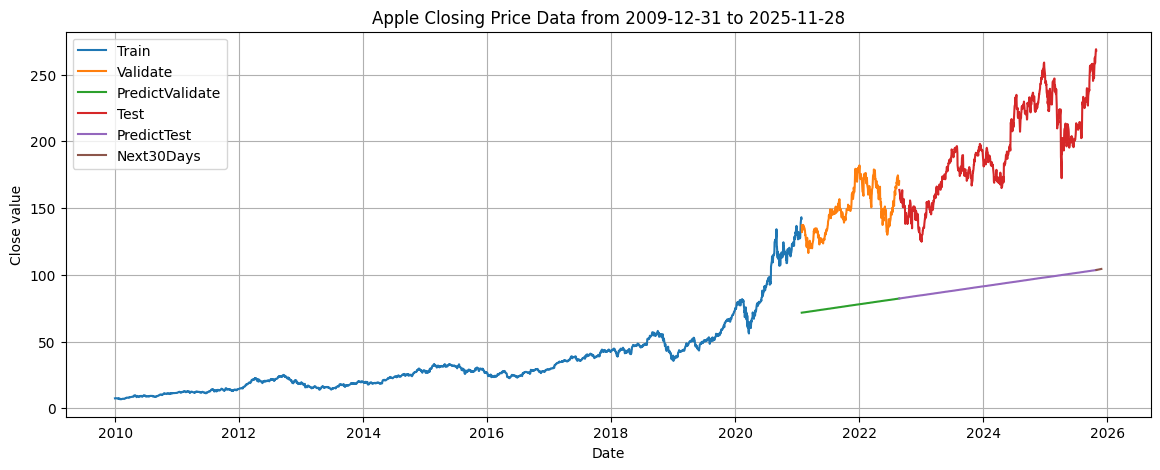

In [12]:
plt.figure(figsize=(14, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.plot(df.index[train_size:train_size + val_size], y_val_inv)
plt.plot(df.index[train_size:train_size + val_size], y_pred_val_inv)
plt.plot(df.index[train_size + val_size:], y_test_inv)
plt.plot(df.index[train_size + val_size:], y_pred_test_inv)
plt.plot(index_next_30_days, y_next_30_days_inv)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Days'])
plt.grid()
plt.title(f"Apple Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('LR_712_Apple.png')
plt.show()
